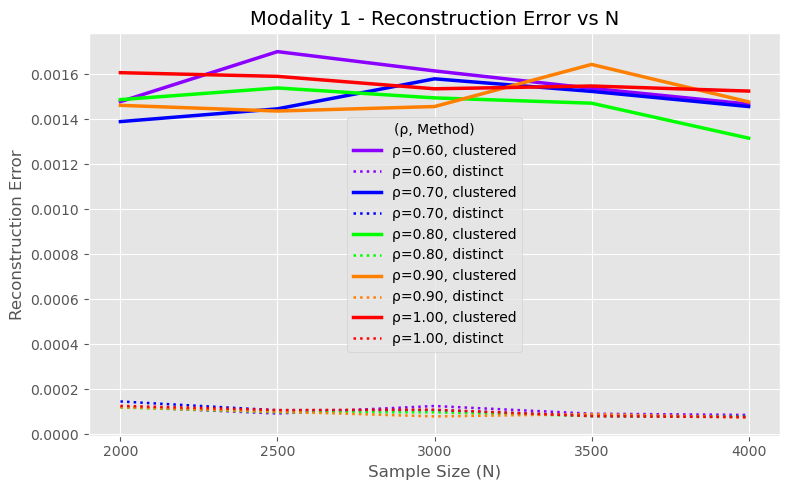

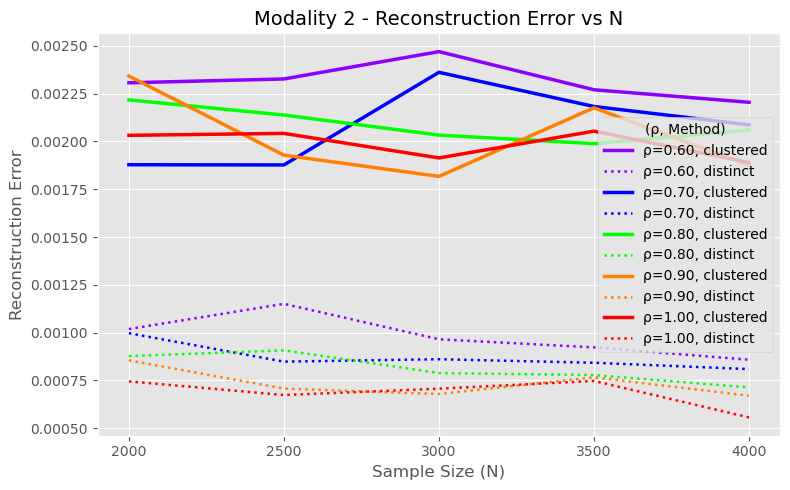

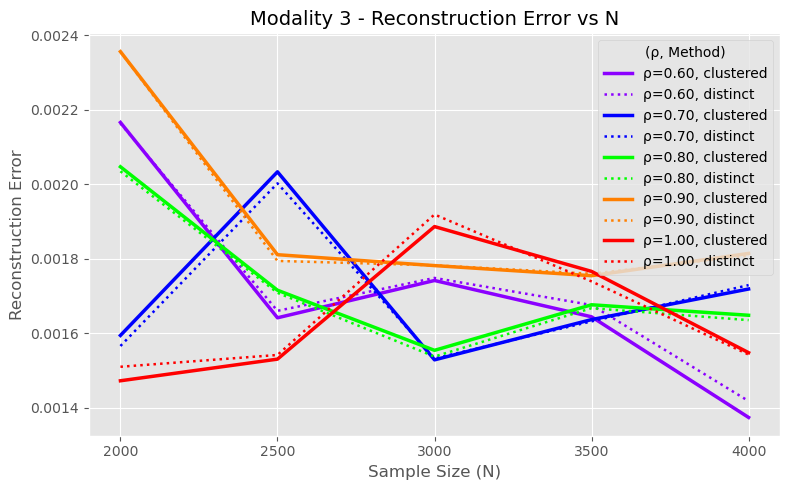

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# --- Setup ---
results_dir = "/home/sagnik/Research/Hierarchical_AMP/Results/vary_rho"
plot_dir = "/home/sagnik/Research/Hierarchical_AMP/Plots/vary_rho"
os.makedirs(plot_dir, exist_ok=True)

# --- Step 1: Load and combine all rho_results_n_*.csv files ---
csv_files = sorted(glob.glob(os.path.join(results_dir, "rho_results_n_*.csv")))

records = []

for file in csv_files:
    n_val = int(os.path.basename(file).split("_")[-1].split(".")[0])  # Extract N
    df = pd.read_csv(file)

    for _, row in df.iterrows():
        records.append({
            "N": n_val,
            "rho": float(row["rho"]),
            "Clustering_Status": row["Method"],
            "Modality": int(row["Modality"]),
            "Error": float(row["Error"])
        })

long_df = pd.DataFrame(records)

# --- Step 2: Save one CSV per modality for ggplot2 ---
for modality in [1, 2, 3]:
    df_mod = long_df[long_df["Modality"] == modality].copy()
    out_path = os.path.join(results_dir, f"modality_{modality}_rho_curve.csv")
    df_mod.to_csv(out_path, index=False)

# --- Step 3: Plotting ---
plt.style.use("ggplot")

# VIBGYOR color list
vibgyor_colors = [
    "#8B00FF",  # Violet
    "#0000FF",  # Blue
    "#00FF00",  # Green
    "#FF7F00",  # Orange
    "#FF0000"   # Red
]

# Get unique rhos and assign VIBGYOR colors
unique_rhos = sorted(long_df["rho"].unique())
if len(unique_rhos) > len(vibgyor_colors):
    raise ValueError("More rho values than VIBGYOR colors provided.")

rho_to_color = {rho: vibgyor_colors[i] for i, rho in enumerate(unique_rhos)}

# Plot for each modality
for modality in [1, 2, 3]:
    plt.figure(figsize=(8, 5))
    df_mod = long_df[long_df["Modality"] == modality]

    for rho in unique_rhos:
        color = rho_to_color[rho]
        for method in ["clustered", "distinct"]:
            sub = df_mod[(df_mod["rho"] == rho) & (df_mod["Clustering_Status"] == method)].sort_values("N")
            linestyle = "-" if method == "clustered" else ":"
            label = f"ρ={rho:.2f}, {method}"
            plt.plot(
                sub["N"], sub["Error"],
                label=label,
                color=color,
                linestyle=linestyle,
                linewidth=2.5 if method == "clustered" else 1.8
            )

    plt.title(f"Modality {modality} - Reconstruction Error vs N", fontsize=14)
    plt.xlabel("Sample Size (N)", fontsize=12)
    plt.ylabel("Reconstruction Error", fontsize=12)
    plt.xticks(sorted(long_df["N"].unique()))
    plt.legend(title="(ρ, Method)", fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f"modality_{modality}_error_vs_n.png"), dpi=150)
    plt.show()

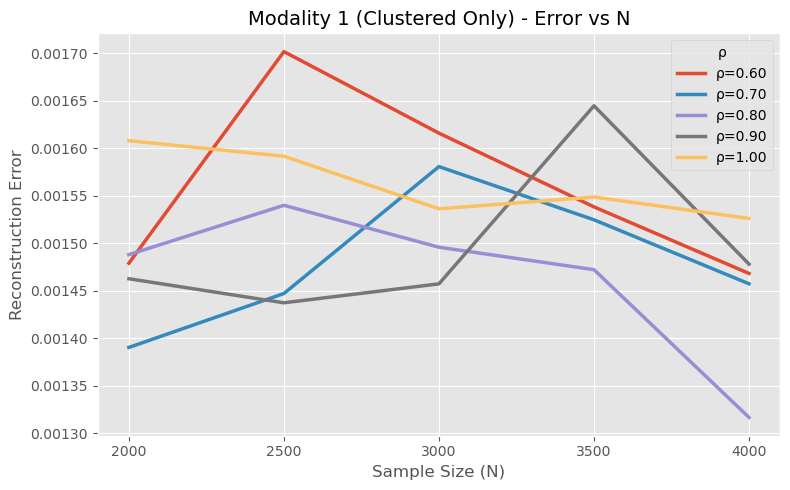

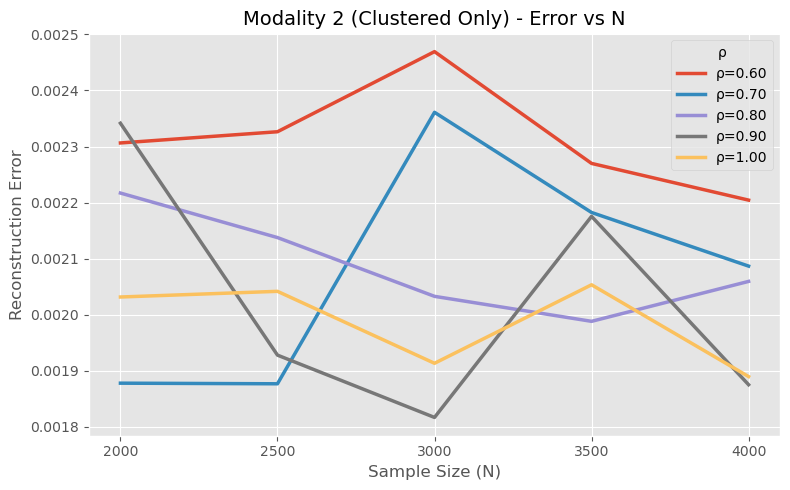

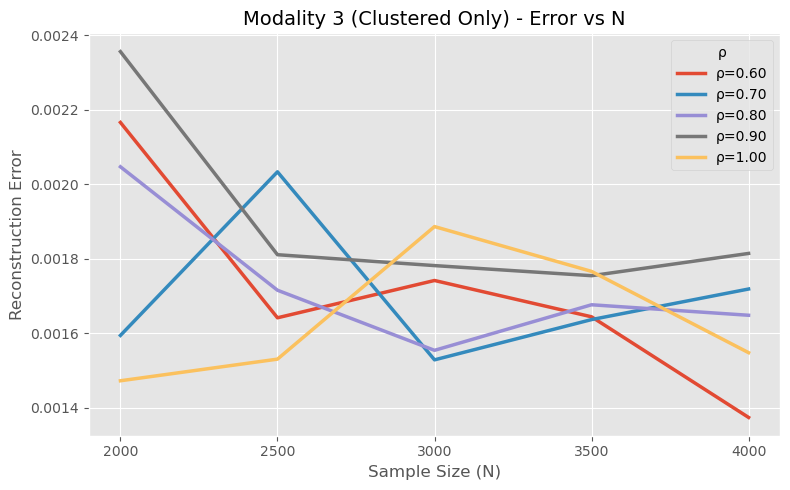

In [2]:
# --- New: Plot only clustered methods ---
clustered_dir = os.path.join(plot_dir, "clustered_only")
os.makedirs(clustered_dir, exist_ok=True)

for modality in [1, 2, 3]:
    plt.figure(figsize=(8, 5))
    df_mod = long_df[(long_df["Modality"] == modality) & (long_df["Clustering_Status"] == "clustered")]

    for rho in sorted(df_mod["rho"].unique()):
        sub = df_mod[df_mod["rho"] == rho].sort_values("N")
        label = f"ρ={rho:.2f}"
        plt.plot(
            sub["N"],
            sub["Error"],
            label=label,
            linestyle='-',
            linewidth=2.5
        )

    plt.title(f"Modality {modality} (Clustered Only) - Error vs N", fontsize=14)
    plt.xlabel("Sample Size (N)", fontsize=12)
    plt.ylabel("Reconstruction Error", fontsize=12)
    plt.xticks(sorted(long_df["N"].unique()))
    plt.legend(title="ρ", fontsize=10)
    plt.tight_layout()

    # Save
    plt.savefig(os.path.join(clustered_dir, f"modality_{modality}_clustered_error_vs_n.png"), dpi=150)
    plt.show()